In [500]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

data=[]
for i in range(10):
    img = cv2.imread('dataset/%s.jpg' %i)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())



In [501]:
import torch
from torch.autograd import Variable

In [502]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))
 
class Perceptron(torch.nn.Module):
 
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(256, 256)  # One in and one out
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
 
# our model
our_model = Perceptron()

In [503]:
def generate_rescaled_inputs(data):
    input_data = []
    
    for i in range(10):
        p = data[i].reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        input_data.append(p)
        
    return input_data

In [504]:
def generate_predictions(data):
    predicted_output = []
    
    for i in range(10):
        p = our_model(Variable(torch.Tensor([data[i]]))).cpu().detach().numpy()
        p = p.reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        predicted_output.append(p)
    
    return predicted_output

In [505]:
def calculate_total_black_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==0)
    return count

In [506]:
def calculate_total_white_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==1)
    return count

In [507]:
def calculate_matching_black_pixels(data1, data2):
    match_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(256):
        match_ctr += 1 if(inp[i]==0 and pred[i]==0) else 0
    return match_ctr

In [508]:
def calculate_mismatching_black_pixels(data1, data2):
    mismatch_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(256):
        mismatch_ctr += 1 if(inp[i]==1 and pred[i]==0) else 0
    return mismatch_ctr

In [509]:
def compute_error_metrics(input_data, predicted_output):
    f_h = []
    f_fa = []
    
    for ix, data in enumerate(input_data):
        total_black_pixels = calculate_total_black_pixels(input_data[ix])
        total_hits = calculate_matching_black_pixels(input_data[ix], predicted_output[ix])
        fh_ratio = float(total_hits/total_black_pixels)
        # print("Fraction of hits is ", total_hits, total_black_pixels)
        f_h.append(fh_ratio)
    
    for ix, data in enumerate(input_data):
        total_white_pixels = calculate_total_white_pixels(input_data[ix])
        total_fa = calculate_mismatching_black_pixels(input_data[ix], predicted_output[ix])
        ffa_ratio = float(total_fa/total_white_pixels)
        # print("Fraction of false alarms is ", total_fa, total_white_pixels)
        f_fa.append(ffa_ratio)
    return f_h, f_fa
    

In [510]:
input_data = generate_rescaled_inputs(data)
predicted_output = generate_predictions(data)

In [511]:
fh, ffa = compute_error_metrics(input_data, predicted_output)

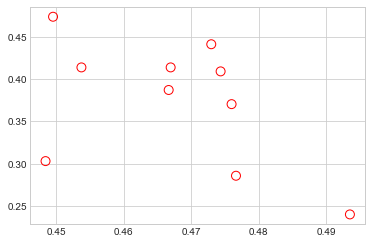

In [512]:
plt.scatter(ffa, fh, s=80, facecolors='none', edgecolors='r')
plt.show()

In [513]:
from random import sample
def add_noise(data, sigma):
    idx = sample(range(256), 25)
    noise = np.random.normal(0, sigma, 25)
    for i in range(25):
        data[idx[i]] += noise[i]
    return data
def normalize(data):
    mini = np.amin(data)
    maxi = np.amax(data)
    for i in range(256):
        data[i] = (data[i] - mini)/(maxi - mini)
    return data

In [514]:
noisy_data = []
for d in data:
    nd = add_noise(np.copy(d), 0.1)
    noisy_data.append(normalize(nd))


In [515]:
for test in range(0, 110, 10):
    our_model = Perceptron()
    
    criterion = torch.nn.MSELoss(size_average = False)
    optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01)
    for epoch in range(test):
    
        # Forward pass: Compute predicted y by passing
        # x to the model
        pred_y = our_model(x_data)
    
        # Compute and print loss
        loss = criterion(pred_y, y_data)
    
        # Zero gradients, perform a backward pass,
        # and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch {}'.format(test))
    
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(noisy_data)
    fh, ffa = compute_error_metrics(target_values, predicted_values)
    print('ffa=', np.mean(ffa))
    print('fh=', np.mean(fh))

/Users/shivambang/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 0
ffa= 0.5317027575904427
fh= 0.49381026807758266
epoch 10
ffa= 0.033968143777718486
fh= 0.6212256186444775
epoch 20
ffa= 0.02694973142840597
fh= 0.6208702297171081
epoch 30
ffa= 0.02122857894876903
fh= 0.7743853548016413
epoch 40
ffa= 0.004413603033463481
fh= 0.8671057112807802
epoch 50
ffa= 0.003956860074333554
fh= 0.9339843260701594
epoch 60
ffa= 0.0004329004329004329
fh= 0.9822720290462226
epoch 70
ffa= 0.0
fh= 0.9922287390029325
epoch 80
ffa= 0.0
fh= 1.0
epoch 90
ffa= 0.0
fh= 1.0
epoch 100
ffa= 0.0
fh= 1.0


[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.8387096774193549, 0.92, 0.727272727272727

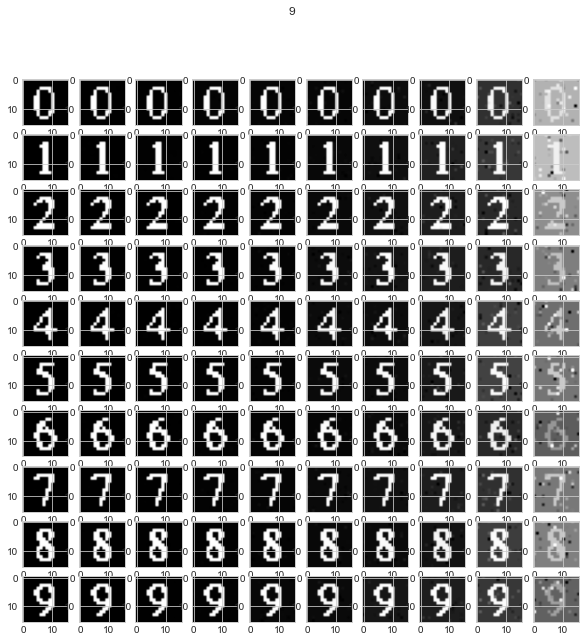

In [516]:
err = []
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 1]
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for s in range(10):
    fig.suptitle(s)
    noisy_data = []
    for d in data:
        nd = add_noise(np.copy(d), sigma[s])
        noisy_data.append(normalize(nd))
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(noisy_data)
    for i in range(10):
        axs[i, s].imshow(noisy_data[i].reshape(16, 16))
    fh, ffa = compute_error_metrics(target_values, predicted_values)
    err.append([fh, ffa])
print(err)